In [138]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
from PIL import Image
import numpy as np
import tqdm.auto
import faiss

ImageType = Image.Image

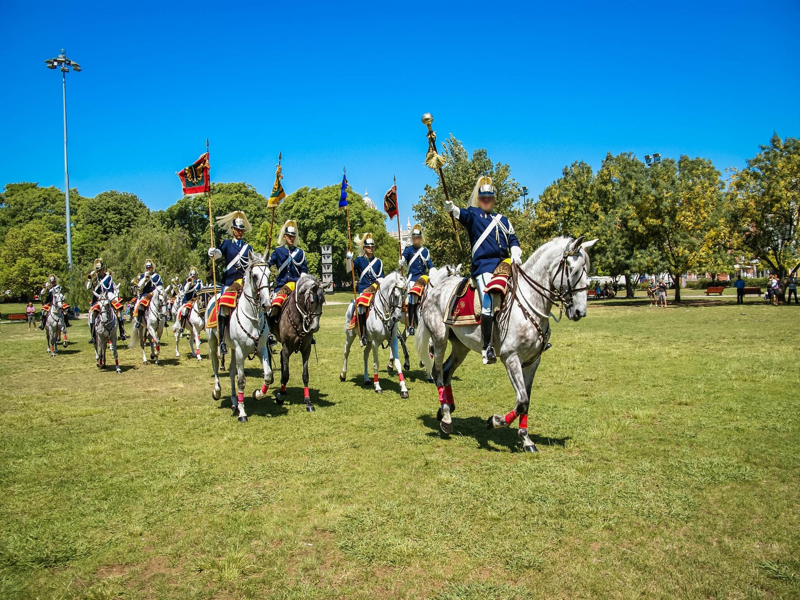

In [140]:
ref = Image.open("./sa_000000/sa_402.jpg")
ref = ref.resize((800, 600))  # .convert("L").convert("RGB")
ref

In [72]:
from itertools import islice
from segmentation.loading import DATA_DIR, images_in_dir

paths = list(islice(images_in_dir(DATA_DIR / "cutouts2"), 10000000))

In [176]:
from segmentation.placement import to_mask


def get_distance(reference: ImageType, overlay: ImageType, with_alpha: bool) -> float:
    assert reference.size == overlay.size
    assert reference.mode == "RGB"

    if with_alpha:
        assert overlay.mode == "RGBA"
        mask = to_mask(overlay)
    else:
        assert overlay.mode == "RGB"
        mask = np.ones(overlay.size).astype(np.bool)

    return np.sum(
        np.abs(
            np.array(reference).astype(np.int32)
            - np.array(overlay)[:, :, :3].astype(np.int32)
        )
        * mask[:, :, np.newaxis]
    ) / np.sum(mask)

In [76]:
collage = Image.new("RGB", ref.size, color="GRAY")

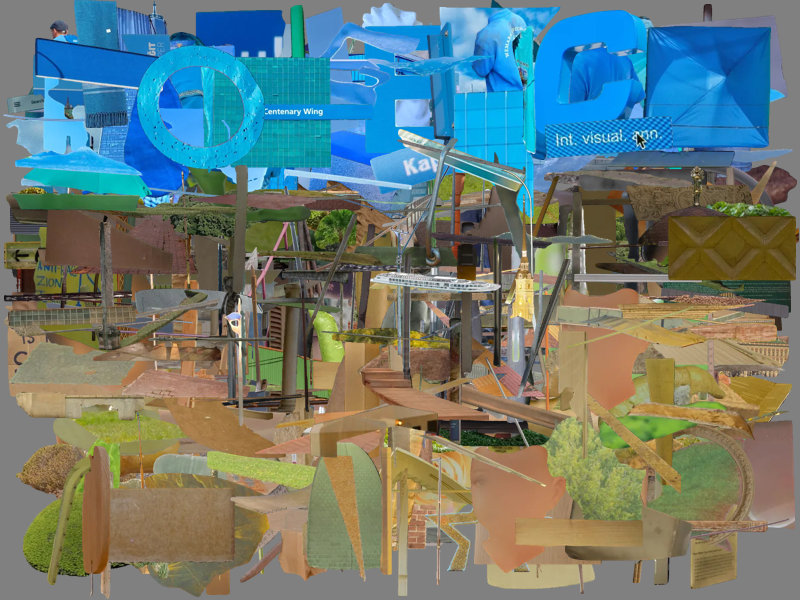

99937 37.1743875


In [78]:
from segmentation.placement import place_image
from IPython.display import display, clear_output

rng = np.random.default_rng()
best_distance = np.inf

for i in tqdm.auto.trange(100000):
    image = Image.open(paths[rng.integers(0, len(paths))])
    image = image.resize((image.size[0] // 2, image.size[1] // 2))
    location = (
        rng.integers(0, ref.size[0] - image.size[0]),
        rng.integers(0, ref.size[1] - image.size[1]),
    )
    new_collage = place_image(collage.convert("RGBA"), image, location).convert("RGB")

    new_distance = get_distance(ref, new_collage)

    if new_distance < best_distance:
        collage = new_collage
        clear_output(wait=True)
        display(collage)
        print(i, new_distance)
        best_distance = new_distance

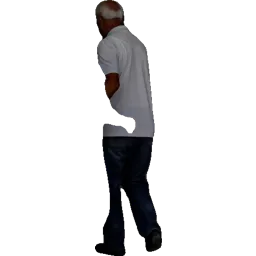

In [84]:
image = Image.open(paths[np.random.default_rng(33).integers(0, len(paths))])
image

In [146]:
from segmentation.hash_index import HashIndex


def get_colored_hash(image: ImageType, size: int = 8) -> np.ndarray:
    # was_rgba = image.mode == "RGBA"
    h = np.array(image.resize((size, size)).convert("RGBA")).astype(np.float32) / 255

    # if was_rgba:
    #     h[:, :, 3] = h[:, :, 3] * -0.2

    return h.flatten()


hash_index = HashIndex(
    max_n_images=100000,
    hash_function=lambda image: get_colored_hash(image, size=8),
    cache_file=DATA_DIR / "cache" / "colored_hash.npy",
)

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

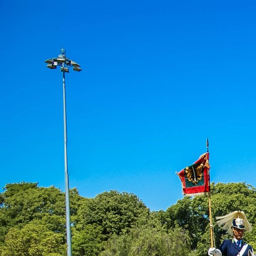

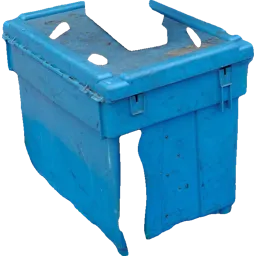

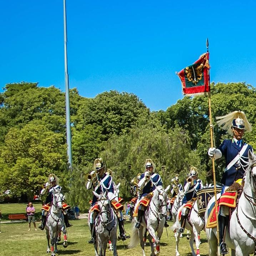

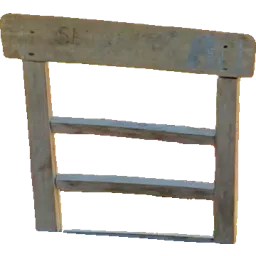

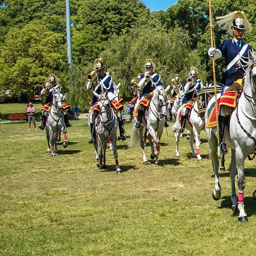

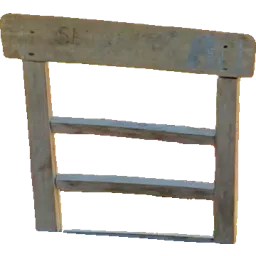

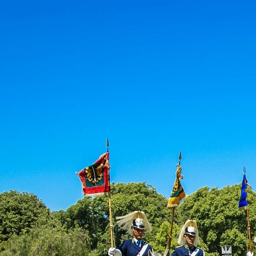

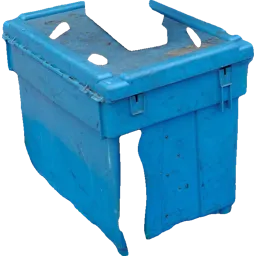

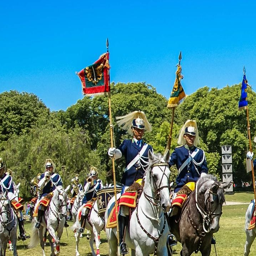

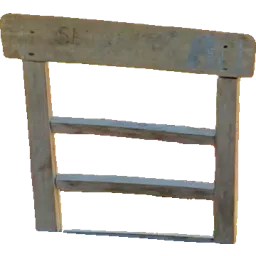

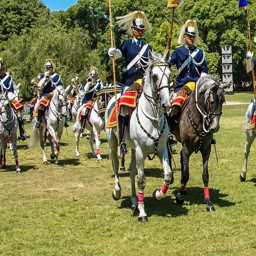

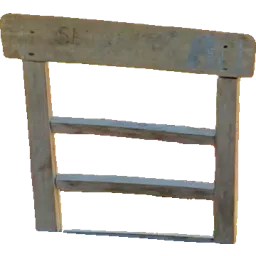

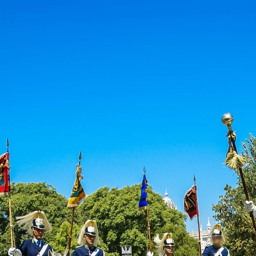

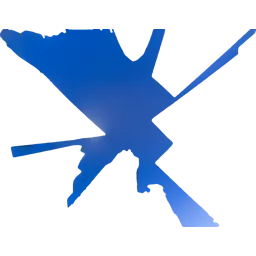

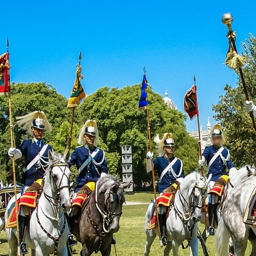

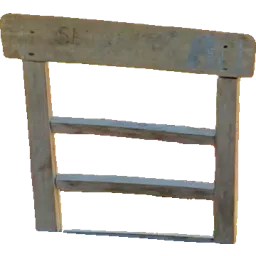

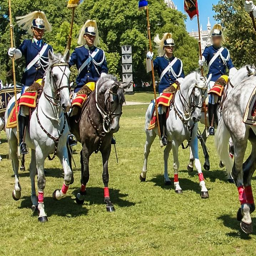

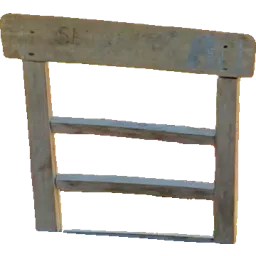

In [137]:
for x in [0, 100, 200]:
    for y in [0, 100, 200]:
        cropped = ref.crop((x, y, x + 256, y + 256))
        display(cropped)
        closest = hash_index.get_closest(cropped, n=3)[0]
        display(Image.open(paths[closest]))

# Reverse direction

In [191]:
from segmentation.shapes import get_edges_hash


hashes = []
positions = []


def get_reference_crop(x, y):
    return ref.crop((x, y, x + 256, y + 256))


for x in range(0, ref.size[0] - 256, 5):
    for y in range(0, ref.size[1] - 256, 5):
        # display(cropped)
        # closest = hash_index.get_closest(cropped, n=3)[0]
        # display(Image.open(paths[closest]))
        hashes.append(get_edges_hash(get_reference_crop(x, y), size=32))
        positions.append((x, y))
        break
    break

hashes = np.array(hashes)

In [192]:
index = faiss.IndexFlatL2(hashes.shape[1])
index.add(hashes)

  0%|          | 0/200000 [00:00<?, ?it/s]

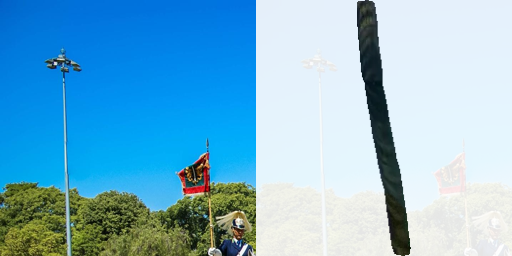

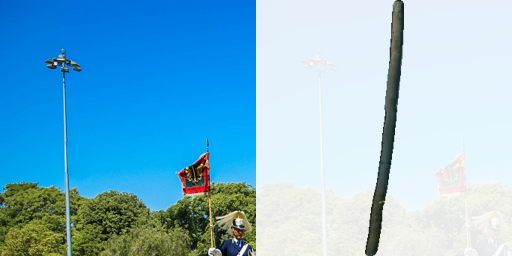

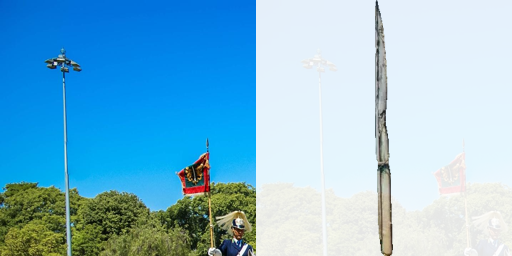

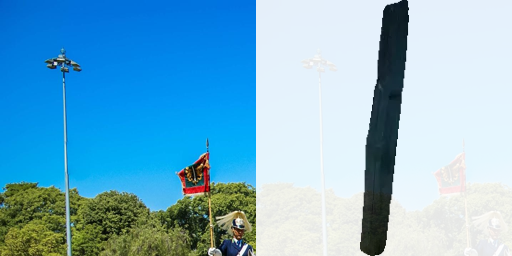

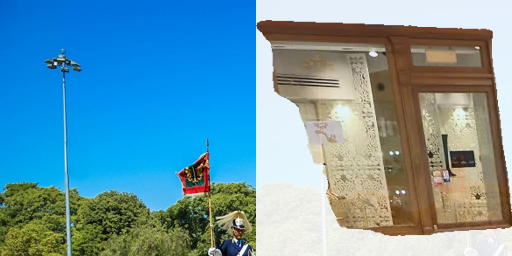

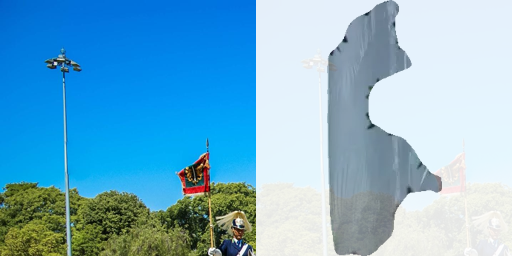

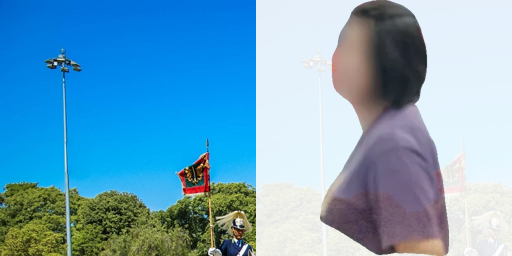

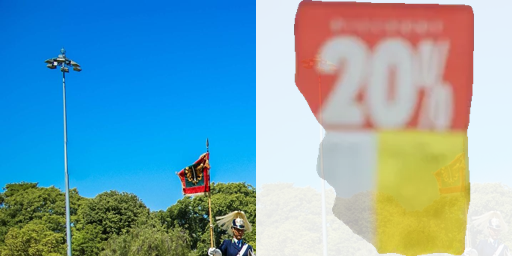

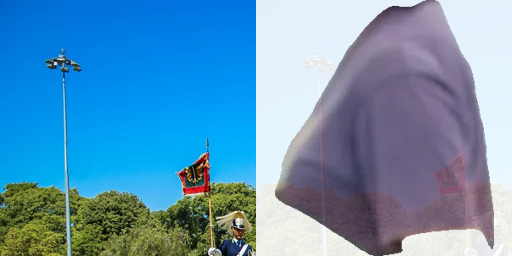

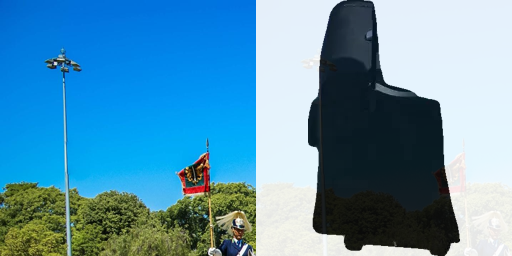

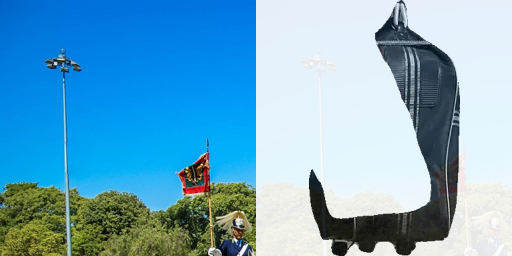

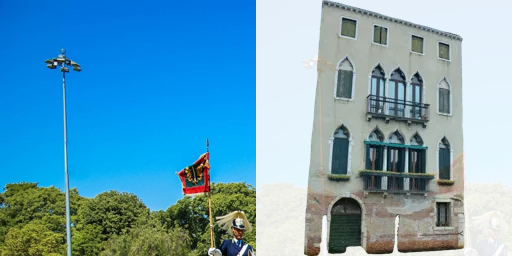

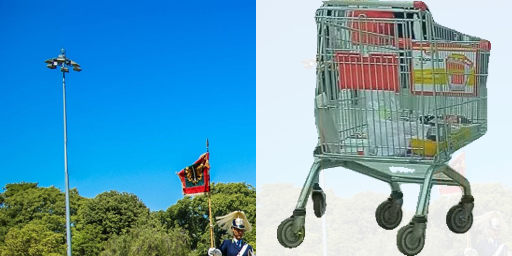

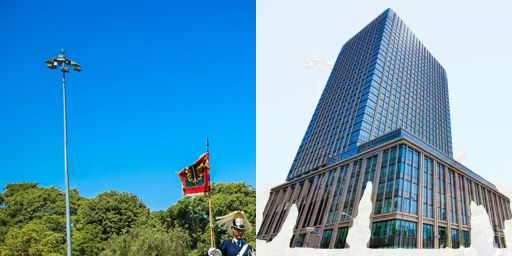

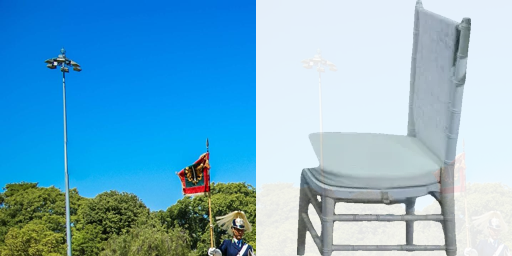

In [193]:
from segmentation.visualization import show_comparison

best_distance = np.inf
best = None

for image in tqdm.auto.tqdm(paths[:200000]):
    image = Image.open(image)
    h = get_edges_hash(image, size=32)
    distances, indices = index.search(h[np.newaxis, :], 3)

    # distance = get_distance(
    #     get_reference_crop(*positions[indices[0][0]]), image, with_alpha=True
    # )
    distance = distances[0][0]
    # display(show_comparison(
    #         get_reference_crop(*positions[indices[0][0]]).convert("RGBA"), image
    #     ))

    if distance < best_distance:
        best_distance = distance
        best = show_comparison(
            get_reference_crop(*positions[indices[0][0]]).convert("RGBA"), image
        )
        display(best)

    # display()
best

In [143]:
ref.size

(800, 600)

In [ ]:
ref.resize